# Python Web Scrapper

Question: can we predict the price of bitcoin?

### 1. Importing the libraries

In [1]:
# data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from scipy.stats import skew
# machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from joblib import dump, load

import warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

### 2. Web Scrapping

In [2]:
BTCURL = "https://finance.yahoo.com/quote/BTC-USD?p=BTC-USD"
r = requests.get(BTCURL)
print(f"Status code: {r.status_code}") # prints the status code
soup = BeautifulSoup(r.text, "html.parser")
print(f"Stock title: {soup.title.text}") # print the title of the stock

Status code: 200
Stock title: Bitcoin USD (BTC-USD) Price, Value, News & History - Yahoo Finance


Extracts the price and change of the bitcoin from the html

In [3]:
price = soup.find("fin-streamer", {"class":"Fw(b) Fz(36px) Mb(-4px) D(ib)"}).text
change = soup.find("fin-streamer", {"class":"Fw(500) Pstart(8px) Fz(24px)"}).text
print(f"Price: {price}, Change: {change}")

Price: 22,528.13, Change: -373.29


Historical stock data

In [4]:
BTC_STOCK_URL = "https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1410912000&period2=1675900800&interval=1d&events=history&includeAdjustedClose=true"
df = pd.read_csv(BTC_STOCK_URL)

### 3. Exploratory data analysis

In [5]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
3063,2023-02-05,23332.248047,23423.435547,22841.759766,22955.666016,22955.666016,19564262605
3064,2023-02-06,22954.021484,23119.279297,22692.025391,22760.109375,22760.109375,23825006542
3065,2023-02-07,22757.267578,23310.974609,22756.257813,23264.291016,23264.291016,27187964471
3066,2023-02-08,23263.416016,23367.958984,22731.097656,22939.398438,22939.398438,25371367758


In [6]:
df.shape # size of the data

(3068, 7)

In [7]:
df.info() # shows variables and their characteristics

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3068 entries, 0 to 3067
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3068 non-null   object 
 1   Open       3068 non-null   float64
 2   High       3068 non-null   float64
 3   Low        3068 non-null   float64
 4   Close      3068 non-null   float64
 5   Adj Close  3068 non-null   float64
 6   Volume     3068 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 167.9+ KB


In [8]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3068.000000,3068.000000,3068.000000,3068.000000,3068.000000,3.068000e+03
mean,12961.395183,13286.317784,12600.505906,12967.034567,12967.034567,1.642961e+10
std,16112.258725,16523.596461,15637.397037,16108.081869,16108.081869,1.987608e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,694.964508,706.027253,678.126999,699.346237,699.346237,1.066862e+08
50%,7218.666260,7384.490234,7045.856933,7218.593750,7218.593750,7.793220e+09
75%,17157.436035,17666.124511,16891.140137,17175.563476,17175.563476,2.789140e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


the category of the data is numeric of continuous type

In [9]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

since the data has no missing values we can skip this step when we start cleaning the data

we can transform the date column to day, month and year

In [10]:
df["Day"] = pd.to_datetime(df["Date"]).dt.day
df["Month"] = pd.to_datetime(df["Date"]).dt.month
df["Year"] = pd.to_datetime(df["Date"]).dt.year
df.drop("Date", axis=1, inplace=True)
df.drop("Adj Close", axis=1, inplace=True)
df.head()

,Open,High,Low,Close,Volume,Day,Month,Year
0,465.864014,468.174011,452.421997,457.334015,21056800,17,9,2014
1,456.859985,456.859985,413.104004,424.440002,34483200,18,9,2014
2,424.102997,427.834991,384.532013,394.795990,37919700,19,9,2014
3,394.673004,423.295990,389.882996,408.903992,36863600,20,9,2014
4,408.084991,412.425995,393.181000,398.821014,26580100,21,9,2014


#### 3.1 Data Visualization

##### 3.1.1 univariate analysis

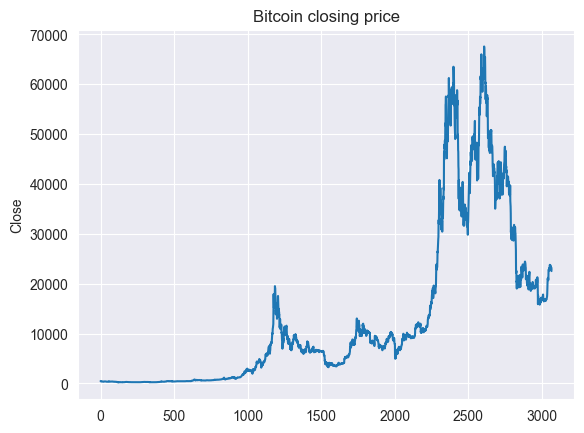

In [11]:
sns.lineplot(df["Close"])
plt.title("Bitcoin closing price")
plt.show()

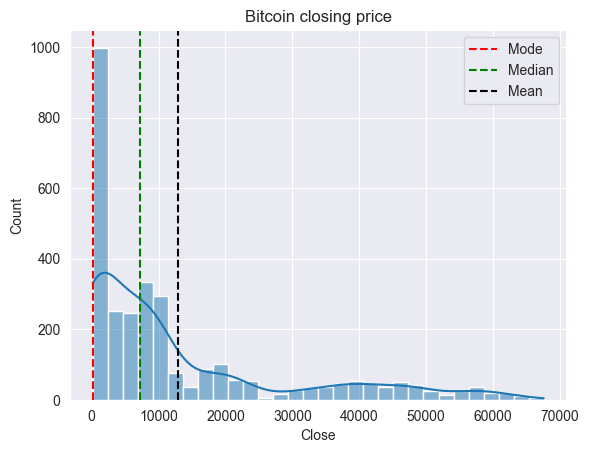

In [12]:
sns.histplot(df["Close"], kde=True)
plt.axvline(df["Close"].mode().values[0],color='red', linestyle='--', label="Mode") # adds a vertical line showing the mode
plt.axvline(np.median(df["Close"]),color='green', linestyle='--', label="Median") # adds a vertical line showing the median
plt.axvline(np.mean(df["Close"]),color='black', linestyle='--', label="Mean") # adds a vertical line showing the mean
plt.legend()
plt.title("Bitcoin closing price")
plt.show()

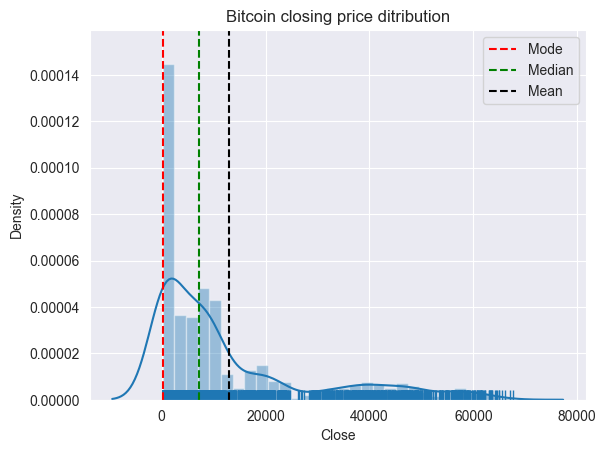

Skewness: 1.526061
Kurtosis: 1.289948


In [13]:
sns.distplot(df["Close"], kde=True, rug=True)
plt.axvline(df["Close"].mode().values[0],color='red', linestyle='--', label="Mode") # adds a vertical line showing the mode
plt.axvline(np.median(df["Close"]),color='green', linestyle='--', label="Median") # adds a vertical line showing the median
plt.axvline(np.mean(df["Close"]),color='black', linestyle='--', label="Mean") # adds a vertical line showing the mean
plt.legend()
plt.title("Bitcoin closing price ditribution")
plt.show()
print("Skewness: %f" % df["Close"].skew())
print("Kurtosis: %f" % df["Close"].kurt())

we can see that the closing price feature has a positive skewness and possibly the other features too so later we will check them

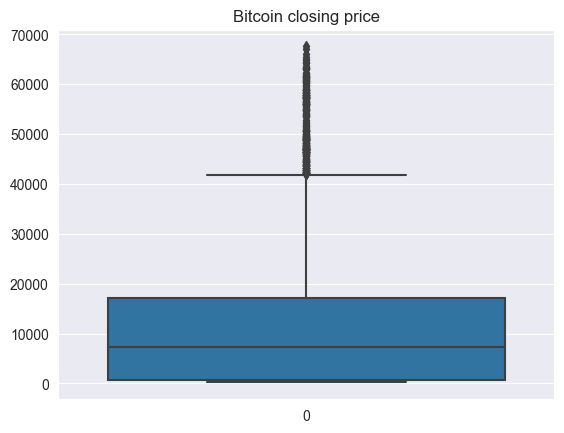

In [14]:
sns.boxplot(df["Close"])
plt.title("Bitcoin closing price")
plt.show()

##### 3.1.2 bivariate and multivariate analysis

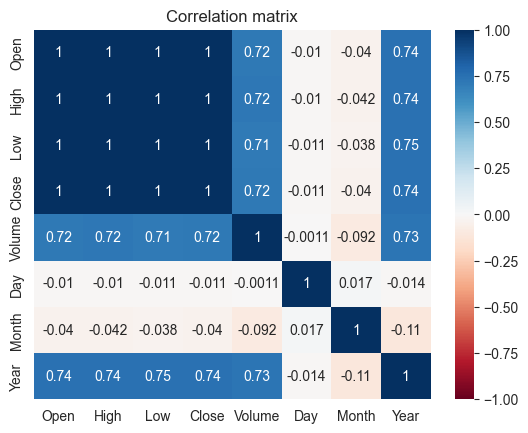

In [15]:
corr = df.corr()
sns.heatmap(corr, cmap="RdBu", vmin= -1, vmax= 1, annot=True)
plt.title("Correlation matrix")
plt.show()

we can see that "Open", "High", "Low","Volume" and "Year" are highly correlated with "Close".

"Day" and "Month" are negatively correlated with all the other variables.

In [16]:
corr_target = abs(corr["Close"]) # Absolute value of correlation
relevant_features = corr_target[corr_target > 0.5] # highly correlated features
names = [index for index, value in relevant_features.iteritems()] # getting the names of the features
names.remove("Close") # removing the target feature

print(names) # printing the features
print(len(names)) # total number of features

['Open', 'High', 'Low', 'Volume', 'Year']
5


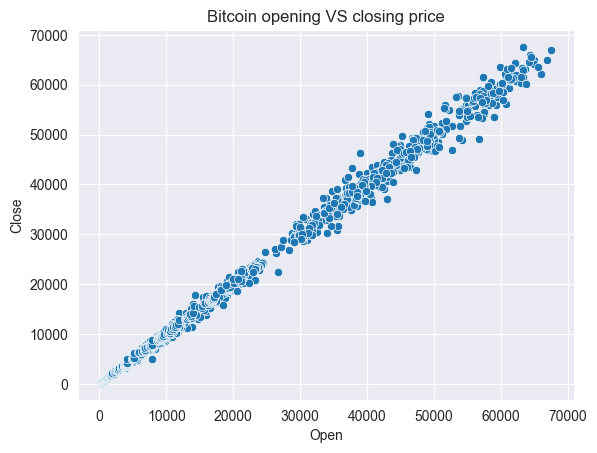

In [17]:
sns.scatterplot(data=df, x="Open", y="Close")
plt.title("Bitcoin opening VS closing price")
plt.show()

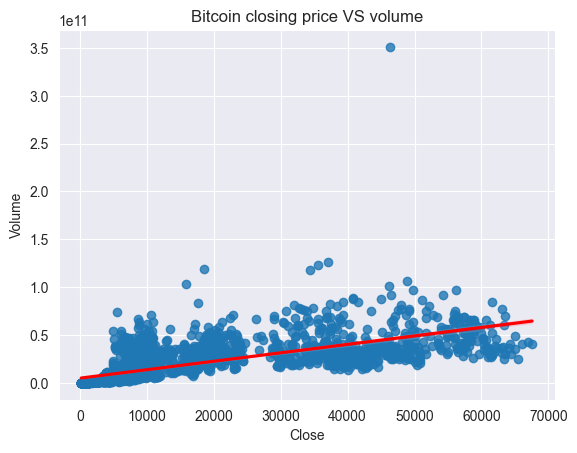

In [18]:
sns.regplot(data=df, x="Close", y="Volume", line_kws={"color": "red"})
plt.title("Bitcoin closing price VS volume")
plt.show()

we can see that the closing price goes up a little bit when the volume goes up

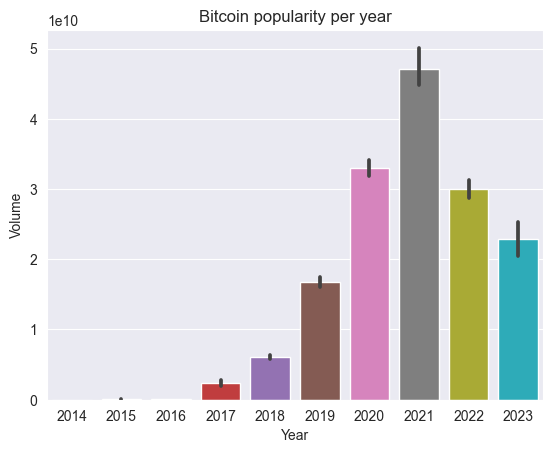

In [19]:
sns.barplot(data=df, x="Year", y="Volume")
plt.title("Bitcoin popularity per year")
plt.show()

we can see that the popularity of bitcoin went up after 2016 since the volume goes up each year reaching a peak in 2021

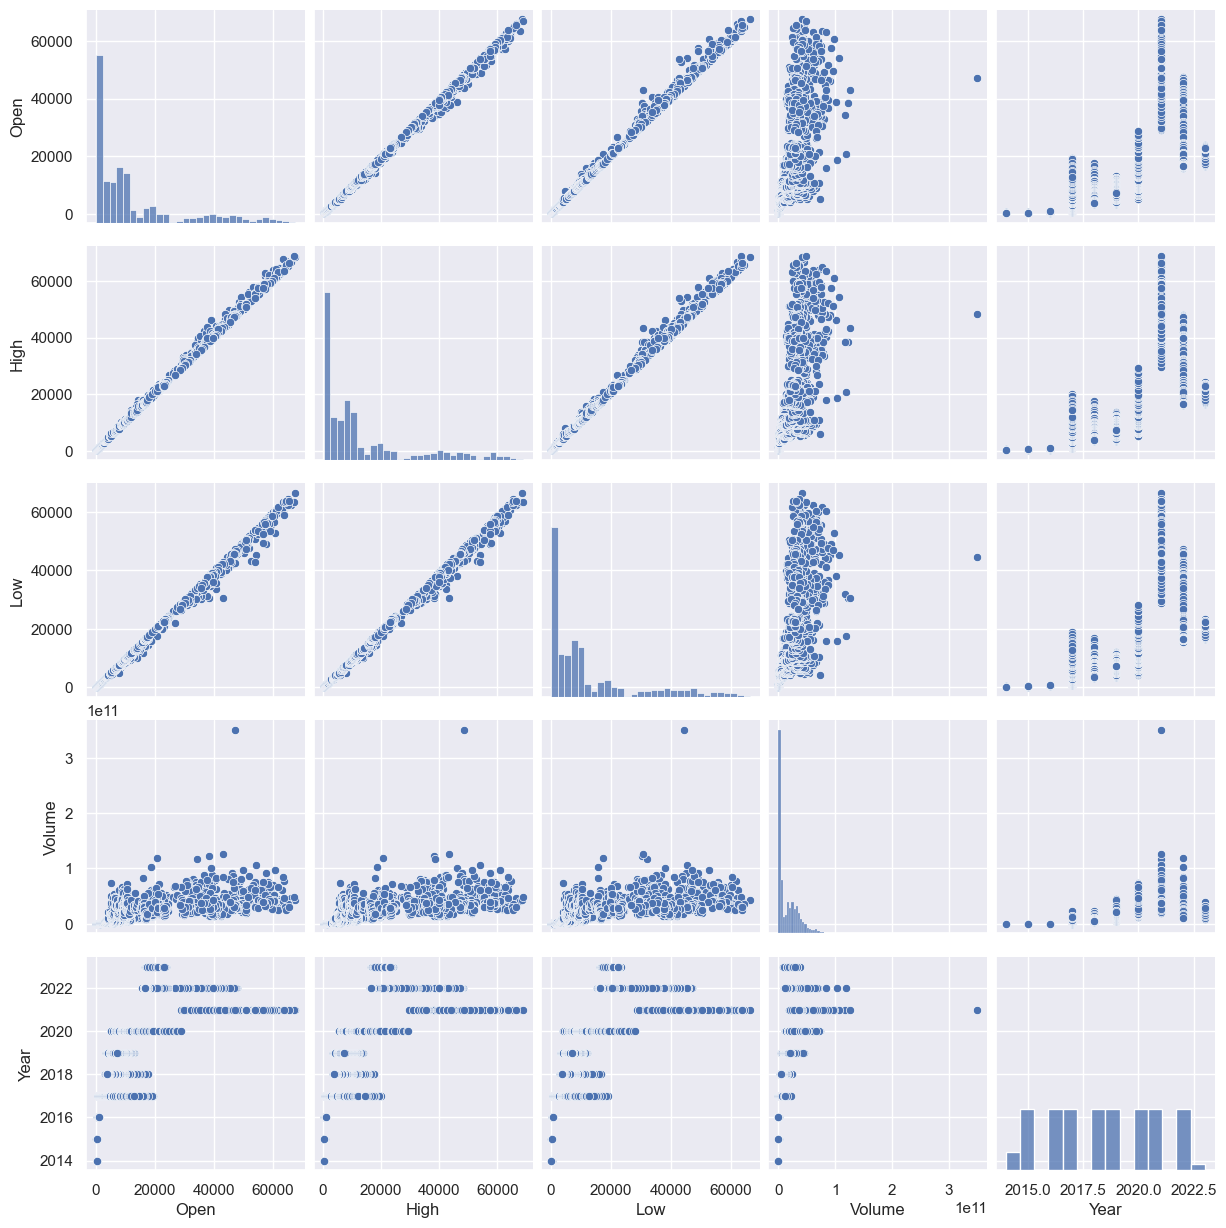

In [20]:
sns.set()
features = ['Open', 'High', 'Low', 'Volume', 'Year']
sns.pairplot(df[features], size=2.5)
plt.show()

although we already saw some of these figures, this plot can give an easy comprehension of the relations between variables

<function matplotlib.pyplot.show(close=None, block=None)>

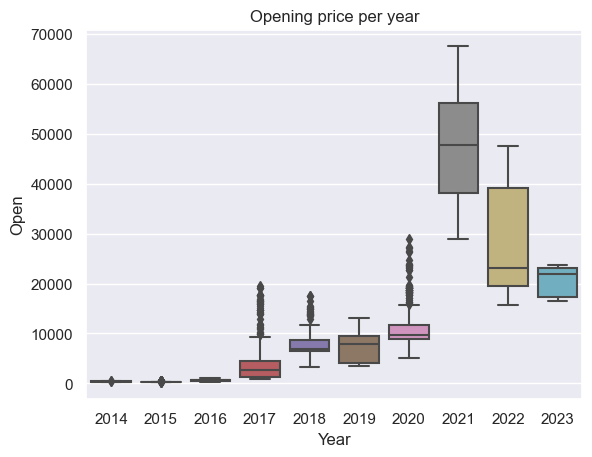

In [21]:
sns.boxplot(data=df,x="Year", y="Open")
plt.title("Opening price per year")
plt.show

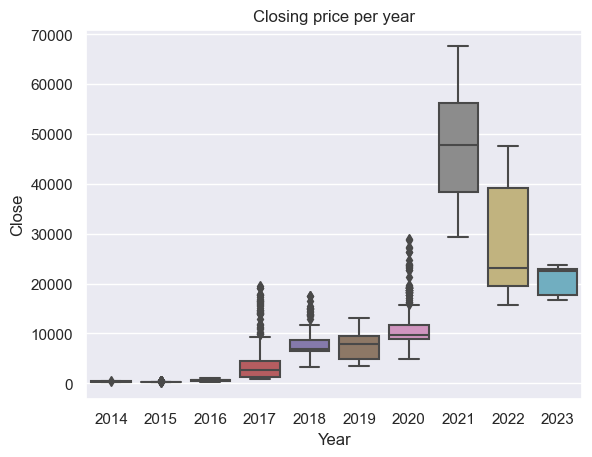

In [22]:
sns.boxplot(data=df,x="Year", y="Close")
plt.title("Closing price per year")
plt.show()

##### 3.1.3 Data Cleaning

What is an outlier?

   An outlier is a data point which is significantly far from other data points.

   Inter-quartile Range (IQR)

   IQR = Q3-Q1

   Lower Boundary = Q1 - 1.5 * IQR

   Upper Boundary = Q3 + 1.5*IQR
   
   Boxplot


In [23]:
# let's handle the outliers
def outliers(df,feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3-Q1
    lowerBound = Q1 - 1.5 * IQR
    upperBound = Q1 + 1.5 * IQR
    
    # Stores the indexes of the outliers in a list
    ls = df.index[ (df[feature] < lowerBound) | (df[feature] > upperBound) ]
    return ls

In [24]:
# create an empty list to store the output indices from multiple columns
index_list = []
for feature in ['Open', 'High', 'Low', 'Volume']:
    # saving the output in the list
    index_list.extend(outliers(df, feature))

In [25]:
index_list

[2293,
 2294,
 2295,
 2296,
 2297,
 2298,
 2299,
 2300,
 2301,
 2302,
 2303,
 2304,
 2305,
 2306,
 2307,
 2308,
 2309,
 2310,
 2311,
 2312,
 2313,
 2314,
 2315,
 2316,
 2317,
 2318,
 2319,
 2320,
 2321,
 2322,
 2323,
 2324,
 2325,
 2326,
 2327,
 2328,
 2329,
 2330,
 2331,
 2332,
 2333,
 2334,
 2335,
 2336,
 2337,
 2338,
 2339,
 2340,
 2341,
 2342,
 2343,
 2344,
 2345,
 2346,
 2347,
 2348,
 2349,
 2350,
 2351,
 2352,
 2353,
 2354,
 2355,
 2356,
 2357,
 2358,
 2359,
 2360,
 2361,
 2362,
 2363,
 2364,
 2365,
 2366,
 2367,
 2368,
 2369,
 2370,
 2371,
 2372,
 2373,
 2374,
 2375,
 2376,
 2377,
 2378,
 2379,
 2380,
 2381,
 2382,
 2383,
 2384,
 2385,
 2386,
 2387,
 2388,
 2389,
 2390,
 2391,
 2392,
 2393,
 2394,
 2395,
 2396,
 2397,
 2398,
 2399,
 2400,
 2401,
 2402,
 2403,
 2404,
 2405,
 2406,
 2407,
 2408,
 2409,
 2410,
 2411,
 2412,
 2413,
 2414,
 2415,
 2416,
 2417,
 2418,
 2419,
 2420,
 2421,
 2422,
 2423,
 2424,
 2425,
 2426,
 2427,
 2428,
 2429,
 2430,
 2431,
 2432,
 2433,
 2434,
 2435,

In [26]:
# define a function called "remove" which returns a cleaned dataframe without outliers
def remove(df, ls):
    # since the index list may not be sorted or unique we need to do some processing ot it
    ls = sorted(set(ls))
    # to remove the rows that contain outliers i will use the drop function from pandas
    df = df.drop(ls)
    # returns the cleaned dataframe
    return df

In [27]:
dfCleaned = remove(df, index_list)

In [28]:
dfCleaned

,Open,High,Low,Close,Volume,Day,Month,Year
0,465.864014,468.174011,452.421997,457.334015,21056800,17,9,2014
1,456.859985,456.859985,413.104004,424.440002,34483200,18,9,2014
2,424.102997,427.834991,384.532013,394.795990,37919700,19,9,2014
3,394.673004,423.295990,389.882996,408.903992,36863600,20,9,2014
4,408.084991,412.425995,393.181000,398.821014,26580100,21,9,2014
...,...,...,...,...,...,...,...,...
3063,23332.248047,23423.435547,22841.759766,22955.666016,19564262605,5,2,2023
3064,22954.021484,23119.279297,22692.025391,22760.109375,23825006542,6,2,2023
3065,22757.267578,23310.974609,22756.257813,23264.291016,27187964471,7,2,2023
3066,23263.416016,23367.958984,22731.097656,22939.398438,25371367758,8,2,2023


In [29]:
print(f"Before: {df.shape}, After{dfCleaned.shape}")

Before: (3068, 8), After(2418, 8)


we can see that we have less rows meaning that we did had outliers and they were eliminated

In [30]:
dfCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2418 entries, 0 to 3067
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2418 non-null   float64
 1   High    2418 non-null   float64
 2   Low     2418 non-null   float64
 3   Close   2418 non-null   float64
 4   Volume  2418 non-null   int64  
 5   Day     2418 non-null   int64  
 6   Month   2418 non-null   int64  
 7   Year    2418 non-null   int64  
dtypes: float64(4), int64(4)
memory usage: 170.0 KB


In [31]:
dfCleaned.describe()

,Open,High,Low,Close,Volume,Day,Month,Year
count,2418.000000,2418.000000,2418.000000,2418.000000,2.418000e+03,2418.000000,2418.000000,2418.000000
mean,5966.556117,6097.269938,5831.045618,5974.922164,9.237644e+09,15.740281,6.807279,2017.662531
std,6150.859892,6278.401309,6019.962576,6159.626288,1.153000e+10,8.805791,3.499524,2.203227
min,176.897003,211.731003,171.509995,178.102997,5.914570e+06,1.000000,1.000000,2014.000000
25%,456.100235,462.066986,452.552750,456.392006,6.810773e+07,8.000000,4.000000,2016.000000
50%,4152.121582,4299.163086,4036.693603,4160.945069,3.868610e+09,16.000000,7.000000,2018.000000
75%,9240.466797,9376.983398,9088.052979,9240.499024,1.710484e+10,23.000000,10.000000,2019.000000
max,24429.056641,25135.589844,24346.115234,24424.068359,4.128043e+10,31.000000,12.000000,2023.000000


What is skewness?

skewness is the unit of assymetry that allows to establish the degree of symmetry that a distribution presents, meaning that the data can be either normally distributed or not.

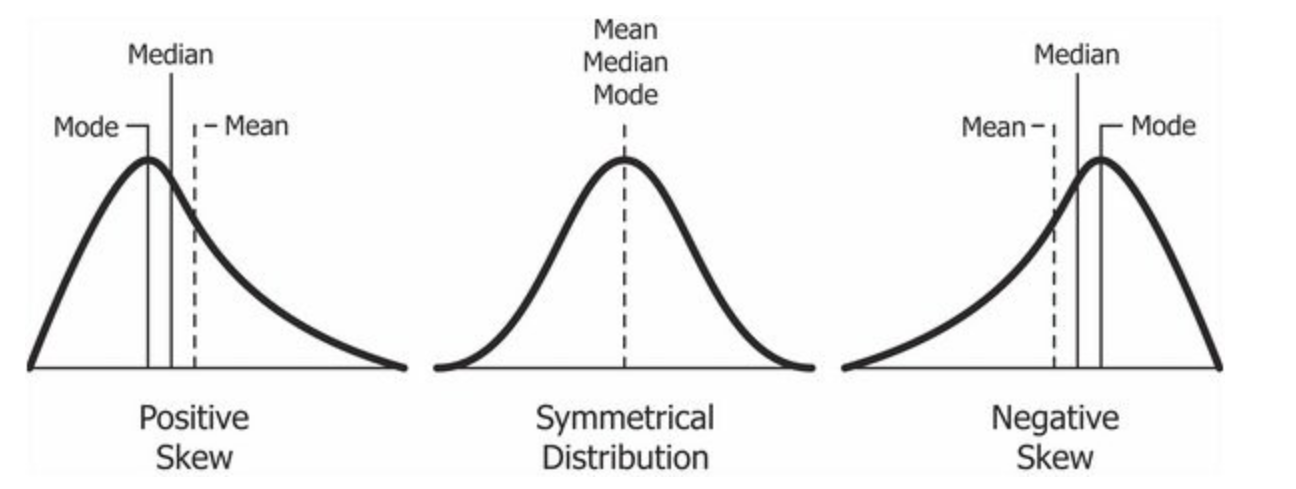

to handle skewness we can use the most common methods : 1) square root transformation or 2) log transformation

Open has a skewness of: 1.0888528925763927


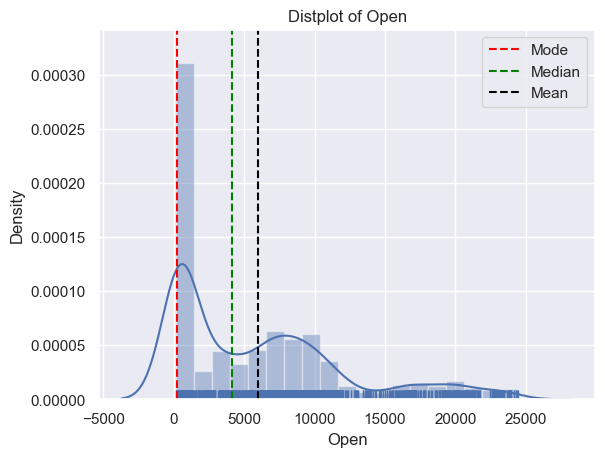

High has a skewness of: 1.081902203967496


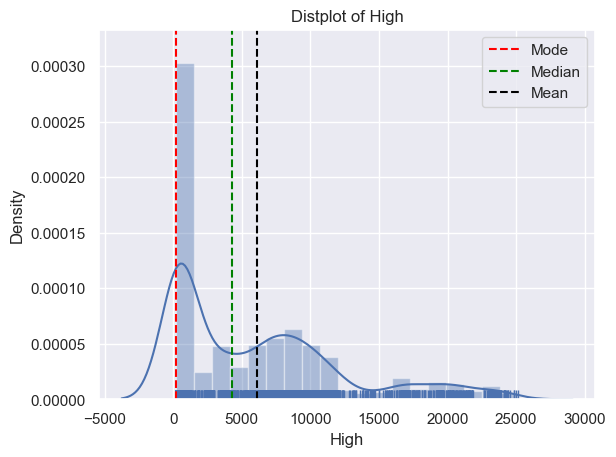

Low has a skewness of: 1.1037803945376672


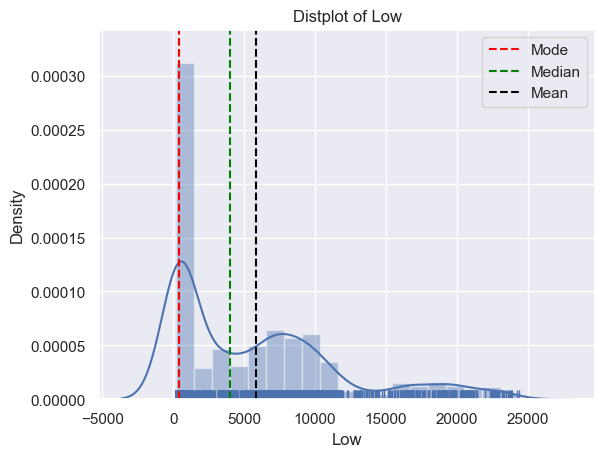

Close has a skewness of: 1.0895494187195531


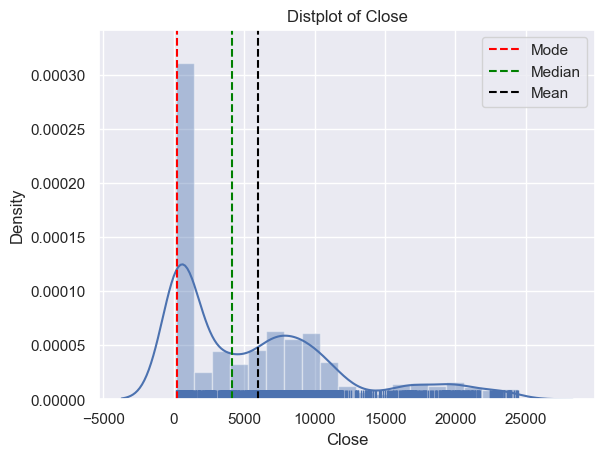

Volume has a skewness of: 1.0846642068767478


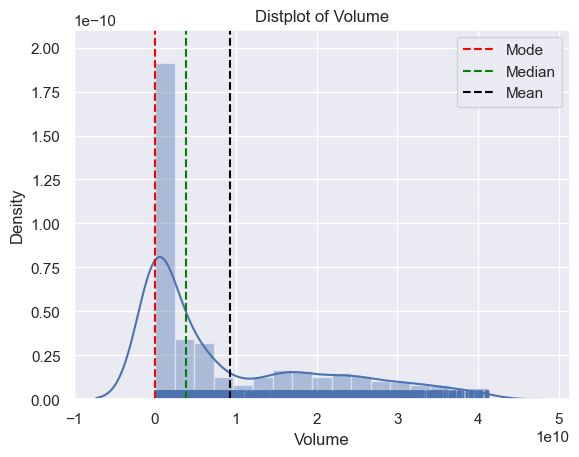

Day has a skewness of: 0.0014199619368906503


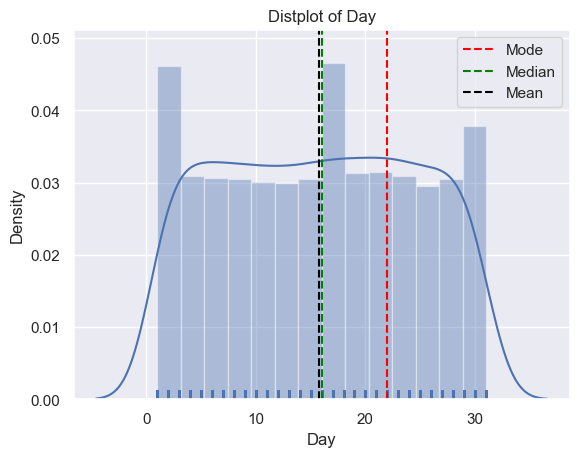

Month has a skewness of: -0.15025260303988738


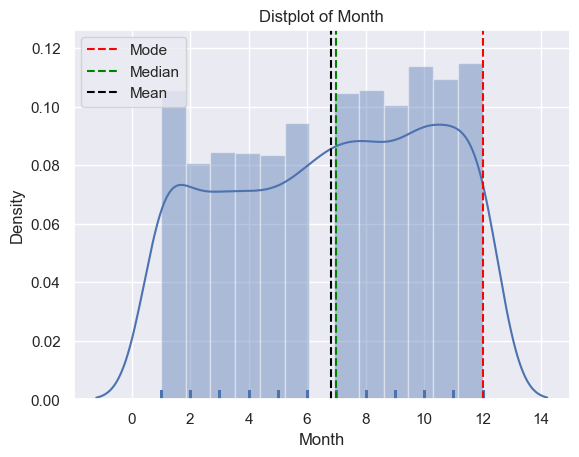

Year has a skewness of: 0.40678697813131387


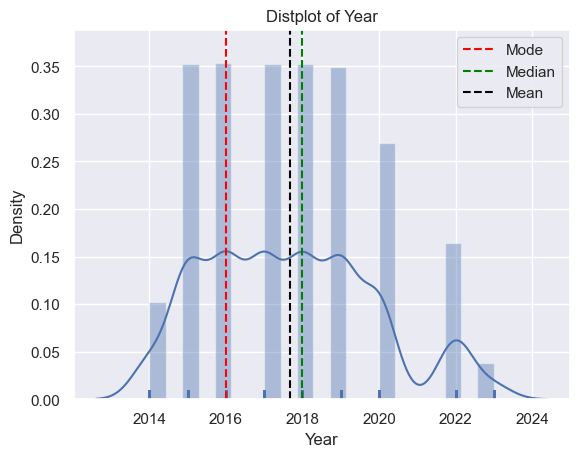

In [32]:
for col in dfCleaned:
    print(f"{col} has a skewness of: {skew(dfCleaned[col])}")
    
    # shows a plot of each feature
    plt.figure()
    sns.distplot(dfCleaned[col], kde=True, rug=True)
    plt.axvline(dfCleaned[col].mode().values[0],color='red', linestyle='--', label="Mode") # adds a vertical line showing the mode
    plt.axvline(np.median(dfCleaned[col]),color='green', linestyle='--', label="Median") # adds a vertical line showing the median
    plt.axvline(np.mean(dfCleaned[col]),color='black', linestyle='--', label="Mean") # adds a vertical line showing the mean
    plt.legend()
    plt.title(f"Distplot of {col}")
    plt.show()

we should only remove the skewness of the features where the correlation with the target is not that great.

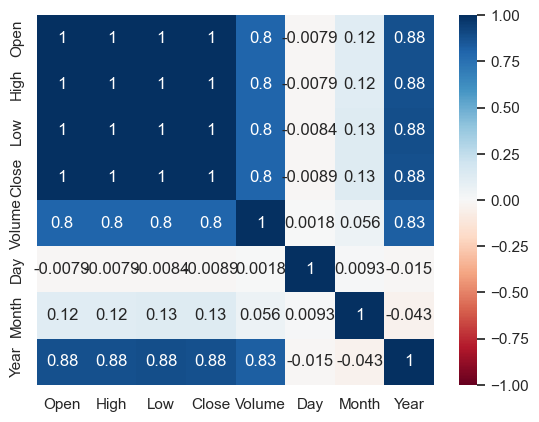

In [33]:
corr = dfCleaned.corr()
sns.heatmap(corr, cmap="RdBu", vmin= -1, vmax= 1, annot=True)
plt.show()

since day and month have a negative correlation and month has a negative skewness we should not apply any of the mentioned methods, and all the others have a high correlation witht the target "Close"

### 4. Machine learning model

In [34]:
cols = ["Day", "Month", "Year", "Close"]
X = dfCleaned.drop(cols, axis=1)
y = dfCleaned["Close"]

In [35]:
X

,Open,High,Low,Volume
0,465.864014,468.174011,452.421997,21056800
1,456.859985,456.859985,413.104004,34483200
2,424.102997,427.834991,384.532013,37919700
3,394.673004,423.295990,389.882996,36863600
4,408.084991,412.425995,393.181000,26580100
...,...,...,...,...
3063,23332.248047,23423.435547,22841.759766,19564262605
3064,22954.021484,23119.279297,22692.025391,23825006542
3065,22757.267578,23310.974609,22756.257813,27187964471
3066,23263.416016,23367.958984,22731.097656,25371367758


In [36]:
y

0         457.334015
1         424.440002
2         394.795990
3         408.903992
4         398.821014
            ...     
3063    22955.666016
3064    22760.109375
3065    23264.291016
3066    22939.398438
3067    22517.263672
Name: Close, Length: 2418, dtype: float64

feature scaling

In [37]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns= X.columns)
X.head()

,Open,High,Low,Volume
0,-0.894481,-0.896767,-0.893649,-0.799523
1,-0.895946,-0.898569,-0.900182,-0.798358
2,-0.901272,-0.903193,-0.904929,-0.798060
3,-0.906058,-0.903916,-0.904040,-0.798151
4,-0.903877,-0.905648,-0.903492,-0.799043


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=40)
print("X_train:- ", X_train.shape)
print("X_test:- ", X_test.shape)
print("y_train:- ", y_train.shape)
print("y_test:- ", y_test.shape)

X_train:-  (1934, 4)
X_test:-  (484, 4)
y_train:-  (1934,)
y_test:-  (484,)


Linear Regression

In [39]:
lr = LinearRegression().fit(X_train, y_train) # training the model

In [40]:
lr_y_pred = lr.predict(X_test)

In [41]:
lr_pred_df = pd.DataFrame({"Actual": y_test, "Predicted":lr_y_pred})
lr_pred_df.head()

,Actual,Predicted
955,1321.790039,1320.017795
452,433.755005,435.966685
86,352.541992,351.070705
1435,6376.709961,6637.649126
810,758.700012,756.517986


In [42]:
print("R2 score:- %f" % r2_score(y_test, lr_y_pred))
print("MSE:- %f" % mean_squared_error(y_test, lr_y_pred))
print("RMSE:- %f" % np.sqrt(mean_squared_error(y_test, lr_y_pred)))

R2 score:- 0.999658
MSE:- 12606.171664
RMSE:- 112.277209


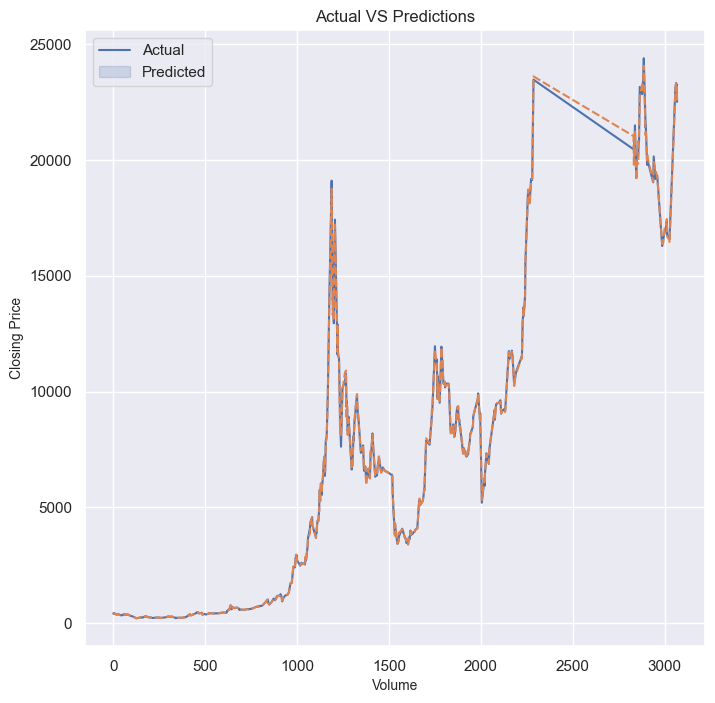

In [43]:
plt.figure(figsize=(8,8))
plt.xlabel('Volume', fontsize=10)
plt.ylabel('Closing Price', fontsize=10)
sns.lineplot(lr_pred_df)
plt.legend(['Actual', 'Predicted'])
plt.title("Actual VS Predictions")
plt.show()

In [44]:
# dump(lr, "btc-lr-predModel.joblib")

In [45]:
# model = load("btc-lr-predModel.joblib")

In [46]:
# open = 22974.87
# high = 22993.58
# low = 22465.10
# volume = 28688957440

In [47]:
# data = [[open,high,low,volume]]
# data = (scaler.fit_transform(data))

In [48]:
# prediction = model.predict(data)
# print(f"The model has predicted that the closing price is: {prediction} $USD")

The model has predicted that the closing price is: [5973.81382274] $USD
